# Egonetworks

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
from dateutil import tz
import sys, os
from importlib import reload  
from IPython.display import display, HTML, display_html
from itertools import chain,cycle
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
from itertools import combinations

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
sns.set_style("darkgrid")
CSS = """
.output {
    display: flex !important;
    flex-direction: row;
}
.output_area{
    width: 100%;
}
"""

HTML('<style>{}</style>'.format(CSS))

def display_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        if isinstance(df, pd.DataFrame):
            html_str+=df.to_html().replace('table','table style="display:inline"')
        else:
            html_str+=str(df)
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [49]:
from egonetwork_analysis import EgoNetworkAnalyzer
members_filename = "random_network.csv"
group_members = pd.read_csv(members_filename)
group_members = group_members[group_members["user_id_from"] != group_members["user_id_to"]]
display(group_members.shape, group_members.head(15))

(64808, 4)

Unnamed: 0      convo_id  user_id_from    user_id_to
1            1  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUwRSlwPyYm
2            2  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUwSjRxLy8/
3            3  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUwSi0SIlBW
4            4  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUwIzxwKisg
5            5  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUwICtxWy43
6            6  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUwITMQO1E1
7            7  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUxSz8JXVpW
8            8  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUxM0oGXFpc
9            9  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUxMyMPLSJQ
10          10  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUxMDFyODAy
11          11  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUxMCh7KC01
12          12  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUxMC0RXCdW
13          13  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUxNksGPlE8
14          14  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUxNT4MKigy
15          15  JFUwID0QPFI/  MlUwRDUMXCQ0  MlUxOU91KlMr

In [50]:
unique_conversations = group_members["convo_id"].drop_duplicates().copy()
display(unique_conversations)

1        JFUwID0QPFI/
13925    JFUwIDR7KlNW
26025    JFUxOD0APFpQ
38794    JFUxODJyIVIz
40819    JFQgMC0ULVQi
             ...     
66516    IyAuSzx2LyU/
66520    IyAuR0sQJ1Y1
66524    IyApMDV6Oyk3
66528    IyApQ0x6IS08
66532    IyAoPkt2LVI1
Name: convo_id, Length: 210, dtype: object

## Unique users in at least one conversation

In [51]:
unique_members = group_members["user_id_from"].drop_duplicates().copy().reset_index(drop=True)
unique_members = pd.DataFrame(unique_members)
display(unique_members.shape, unique_members.head(15))

(175, 1)

user_id_from
0   MlUwRDUMXCQ0
1   MlUwRSlwPyYm
2   MlUwSjRxLy8/
3   MlUwSi0SIlBW
4   MlUwIzxwKisg
5   MlUwICtxWy43
6   MlUwITMQO1E1
7   MlUxSz8JXVpW
8   MlUxM0oGXFpc
9   MlUxMyMPLSJQ
10  MlUxMDFyODAy
11  MlUxMCh7KC01
12  MlUxMC0RXCdW
13  MlUxNksGPlE8
14  MlUxNT4MKigy

## All users in the workspace

In [52]:
all_users_filename = "random_users_list.csv"
all_users = pd.read_csv(all_users_filename)
all_users.head(15)

Unnamed: 0       user_id
0            0  MjIuMzoJKywx
1            1  MlUwRDUMXCQ0
2            2  MlUwRSlwPyYm
3            3  MlUwSjRxLy8/
4            4  MlUwSi0SIlBW
5            5  MlUwS0gGWyRU
6            6  MlUwIzxwKisg
7            7  MlUwICtxWy43
8            8  MlUwITMQO1E1
9            9  MlUwJzIUXSYr
10          10  MlUxQzd3P1ok
11          11  MlUxSz8JXVpW
12          12  MlUxM0oGXFpc
13          13  MlUxMzMKPS4/
14          14  MlUxMyMPLSJQ

## Users not in any conversation

In [53]:
merged_df = all_users.merge(unique_members,how='left', left_on="user_id", right_on="user_id_from", indicator=True)
users_not_active = merged_df[merged_df["_merge"] != "both"]
active_users = merged_df[merged_df["_merge"] == "both"]
display(active_users.shape)
display_side(merged_df, users_not_active, titles=['All users','Users NOT in any conversation'])

(165, 4)

All users 
 
 
 
 Unnamed: 0 
 user_id 
 user_id_from 
 _merge 
 
 
 
 
 0 
 0 
 MjIuMzoJKywx 
 NaN 
 left_only 
 
 
 1 
 1 
 MlUwRDUMXCQ0 
 MlUwRDUMXCQ0 
 both 
 
 
 2 
 2 
 MlUwRSlwPyYm 
 MlUwRSlwPyYm 
 both 
 
 
 3 
 3 
 MlUwSjRxLy8/ 
 MlUwSjRxLy8/ 
 both 
 
 
 4 
 4 
 MlUwSi0SIlBW 
 MlUwSi0SIlBW 
 both 
 
 
 5 
 5 
 MlUwS0gGWyRU 
 NaN 
 left_only 
 
 
 6 
 6 
 MlUwIzxwKisg 
 MlUwIzxwKisg 
 both 
 
 
 7 
 7 
 MlUwICtxWy43 
 MlUwICtxWy43 
 both 
 
 
 8 
 8 
 MlUwITMQO1E1 
 MlUwITMQO1E1 
 both 
 
 
 9 
 9 
 MlUwJzIUXSYr 
 NaN 
 left_only 
 
 
 10 
 10 
 MlUxQzd3P1ok 
 MlUxQzd3P1ok 
 both 
 
 
 11 
 11 
 MlUxSz8JXVpW 
 MlUxSz8JXVpW 
 both 
 
 
 12 
 12 
 MlUxM0oGXFpc 
 MlUxM0oGXFpc 
 both 
 
 
 13 
 13 
 MlUxMzMKPS4/ 
 NaN 
 left_only 
 
 
 14 
 14 
 MlUxMyMPLSJQ 
 MlUxMyMPLSJQ 
 both 
 
 
 15 
 15 
 MlUxMDFyODAy 
 MlUxMDFyODAy 
 both 
 
 
 16 
 16 
 MlUxMCh7KC01 
 MlUxMCh7KC01 
 both 
 
 
 17 
 17 
 MlUxMC0RXCdW 
 MlUxMC0RXCdW 
 both 
 
 
 18 
 18 
 MlUxNksGPlE8 
 MlUxNksGPlE8 
 both 
 
 
 19 
 19 
 MlUxNEtyP1Mm 
 NaN 
 left_only 
 
 
 20 
 20 
 MlUxNUAMUSAh 
 NaN 
 left_only 
 
 
 21 
 21 
 MlUxNT4MKigy 
 MlUxNT4MKigy 
 both 
 
 
 22 
 22 
 MlUxOU91KlMr 
 MlUxOU91KlMr 
 both 
 
 
 23 
 23 
 MlUxOU8FIlBd 
 MlUxOU8FIlBd 
 both 
 
 
 24 
 24 
 MlUxOT0HXldT 
 MlUxOT0HXldT 
 both 
 
 
 25 
 25 
 MlU2QE0QIy5d 
 MlU2QE0QIy5d 
 both 
 
 
 26 
 26 
 MlU2QDx7ITIy 
 MlU2QDx7ITIy 
 both 
 
 
 27 
 27 
 MlU2RToFX1Ey 
 MlU2RToFX1Ey 
 both 
 
 
 28 
 28 
 MlU2Skp1XSgz 
 MlU2Skp1XSgz 
 both 
 
 
 29 
 29 
 MlU3ODtwOFVT 
 MlU3ODtwOFVT 
 both 
 
 
 30 
 30 
 MlU0RCAQWlIr 
 NaN 
 left_only 
 
 
 31 
 31 
 MlU0RS13Oykk 
 MlU0RS13Oykk 
 both 
 
 
 32 
 32 
 MlU1IEt1PjAi 
 MlU1IEt1PjAi 
 both 
 
 
 33 
 33 
 MlU6MEoOWVoj 
 NaN 
 left_only 
 
 
 34 
 34 
 MlU6JEhyWlZU 
 NaN 
 left_only 
 
 
 35 
 35 
 MlRQMU97MCQv 
 MlRQMU97MCQv 
 both 
 
 
 36 
 36 
 MlRVME0TITdR 
 MlRVME0TITdR 
 both 
 
 
 37 
 37 
 MlQjQ0F0WlE0 
 MlQjQ0F0WlE0 
 both 
 
 
 38 
 38 
 MlQgRCEDWDcv 
 NaN 
 left_only 
 
 
 39 
 39 
 MlQhRzoBMVQw 
 MlQhRzoBMVQw 
 both 
 
 
 40 
 40 
 MlQhME4RKlY3 
 MlQhME4RKlY3 
 both 
 
 
 41 
 41 
 MlQmQj16MyVU 
 MlQmQj16MyVU 
 both 
 
 
 42 
 42 
 MlQkIipzXTdU 
 MlQkIipzXTdU 
 both 
 
 
 43 
 43 
 MlQpPiNwJDVX 
 MlQpPiNwJDVX 
 both 
 
 
 44 
 44 
 MldXPkoGJC9W 
 MldXPkoGJC9W 
 both 
 
 
 45 
 45 
 MlchNjIELlAk 
 MlchNjIELlAk 
 both 
 
 
 46 
 46 
 MlcyIigXKCVR 
 MlcyIigXKCVR 
 both 
 
 
 47 
 47 
 Mlc3M0kHOlsu 
 Mlc3M0kHOlsu 
 both 
 
 
 48 
 48 
 MlYzSyEBKCY3 
 NaN 
 left_only 
 
 
 49 
 49 
 MlY2QzMEXyIy 
 NaN 
 left_only 
 
 
 50 
 50 
 MlY2OT4RMTMw 
 MlY2OT4RMTMw 
 both 
 
 
 51 
 51 
 MlY3ICB1Xi0w 
 MlY3ICB1Xi0w 
 both 
 
 
 52 
 52 
 MllbRkkFMyUy 
 MllbRkkFMyUy 
 both 
 
 
 53 
 53 
 MlkjSk1zUSUr 
 MlkjSk1zUSUr 
 both 
 
 
 54 
 54 
 MlhQQk4FJ1cw 
 MlhQQk4FJ1cw 
 both 
 
 
 55 
 55 
 MlhXIykGWyE9 
 MlhXIykGWyE9 
 both 
 
 
 56 
 56 
 MlhUNSEEIiAr 
 MlhUNSEEIiAr 
 both 
 
 
 57 
 57 
 Mlg3NigWPSBS 
 NaN 
 left_only 
 
 
 58 
 58 
 MiBaIy4AJy9c 
 NaN 
 left_only 
 
 
 59 
 59 
 MiBbOjcQOlMo 
 MiBbOjcQOlMo 
 both 
 
 
 60 
 60 
 MiAlREATOVtd 
 MiAlREATOVtd 
 both 
 
 
 61 
 61 
 MiAlIz8KWFYi 
 MiAlIz8KWFYi 
 both 
 
 
 62 
 62 
 MiAqMU8XWClS 
 MiAqMU8XWClS 
 both 
 
 
 63 
 63 
 MiAoNCoAWVYh 
 MiAoNCoAWVYh 
 both 
 
 
 64 
 64 
 MiAuSkt7LFoo 
 MiAuSkt7LFoo 
 both 
 
 
 65 
 65 
 MiAvQk1wMDAu 
 MiAvQk1wMDAu 
 both 
 
 
 66 
 66 
 MiAyQyETLFJQ 
 MiAyQyETLFJQ 
 both 
 
 
 67 
 67 
 MiAzRksWMyQz 
 NaN 
 left_only 
 
 
 68 
 68 
 MiNSOSAEMCgg 
 MiNSOSAEMCgg 
 both 
 
 
 69 
 69 
 MiNTQiwOLSIo 
 NaN 
 left_only 
 
 
 70 
 70 
 MiMhPE52OFog 
 MiMhPE52OFog 
 both 
 
 
 71 
 71 
 MiMuRSEQXDY8 
 MiMuRSEQXDY8 
 both 
 
 
 72 
 72 
 MiM0OisFXzNc 
 MiM0OisFXzNc 
 both 
 
 
 73 
 73 
 MiJQQT4FPSQk 
 NaN 
 left_only 
 
 
 74 
 74 
 MiJQRTJwPCk/ 
 NaN 
 left_only 
 
 
 75 
 75 
 MiJRRjN0Jzc/ 
 NaN 
 left_only 
 
 
 76 
 76 
 MiJRNjx6WDVR 
 NaN 
 left_only 
 
 
 77 
 77 
 MiIgJyEELyUt 
 MiIgJyEELyUt 
 both 
 
 
 78 
 78 
 MiI1MEFxUC4i 
 MiI1MEFxUC4i 
 both 
 
 

## Unique edges
I'm calculating the unique edges by grouping by `user_id_from` and `user_id_to` so that we only have unique pairings.
I can then count how many unique edges two users have to have an idea of their tie strength

In [54]:
members_ties = group_members.groupby(["user_id_from", "user_id_to"]).agg(tie_strength=("convo_id", "nunique")).sort_values("tie_strength", ascending=False).reset_index()
members_ties.head(10)

user_id_from    user_id_to  tie_strength
0  MlUwRDUMXCQ0  MiAoNCoAWVYh            63
1  MiAoNCoAWVYh  MlUwRDUMXCQ0            63
2  MiAoNCoAWVYh  MlUwICtxWy43            51
3  MlUwICtxWy43  MiAoNCoAWVYh            51
4  MiAoNCoAWVYh  MiAvQk1wMDAu            51
5  MiAvQk1wMDAu  MiAoNCoAWVYh            51
6  MiAoNCoAWVYh  MlUxNT4MKigy            50
7  MlUxNT4MKigy  MiAoNCoAWVYh            50
8  MlhQQk4FJ1cw  MiAoNCoAWVYh            49
9  MiAoNCoAWVYh  MlhQQk4FJ1cw            49

If we have a total of 166 users that are *at least* in a channel we expect an upper bound of nxn = 166 x 166 = 27 556 nodes at most

## Egonetwork
There is some pretty cool stuff [here](https://www.python-graph-gallery.com/chord-diagram-python-chord)

Interesting read here: https://faculty.ucr.edu/~hanneman/nettext/C9_Ego_networks.html

## Util Functions

## Sampling a few conversations and showing their networks

convo_id
64373  ICwlSk17Xi88

user_id_from    user_id_to  tie_strength
0         Mi0nRTRzLFch  Mi1VJi52Iygx             1
1     MlFTRCAXWFsuYng=  MldXPkoGJC9W             1
2         MlQjQ0F0WlE0  MiAoNCoAWVYh             1
3         MlQjQ0F0WlE0  MiAlIz8KWFYi             1
4         MlQjQ0F0WlE0  Mi8oQSgSLSEp             1
...                ...           ...           ...
1255      MiZbMTQAXFdX  MllbRkkFMyUy             1
1256      MiZbMTQAXFdX  MlhQQk4FJ1cw             1
1257      MiZbMTQAXFdX  MldXPkoGJC9W             1
1258      MiZbMTQAXFdX  MlUxOU8FIlBd             1
1259      MllbRkkFMyUy  MlhQQk4FJ1cw             1

[1260 rows x 3 columns]

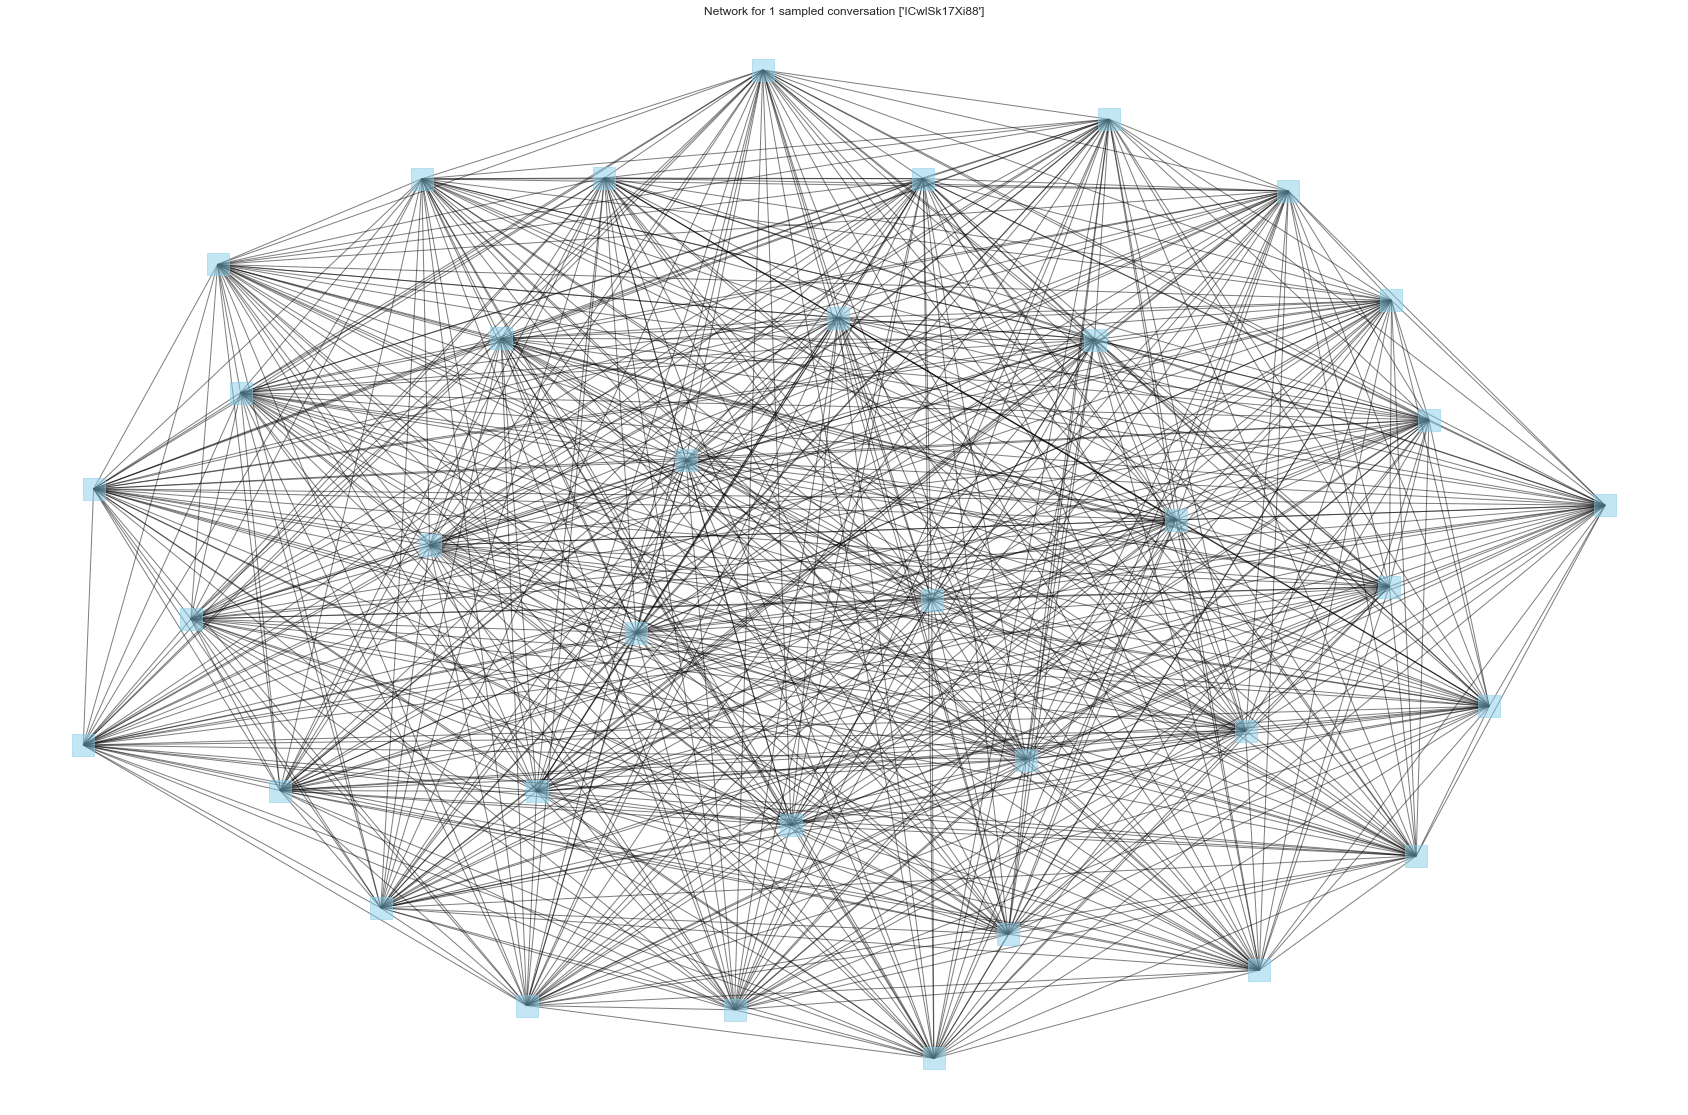

In [60]:
sampled_channels_n = 1
sampled_channels = group_members[["convo_id"]].sample(sampled_channels_n)
sampled_channels_list =  sampled_channels["convo_id"].drop_duplicates().to_list()
sampled_channels_n = len(sampled_channels_list)
display(sampled_channels)
sampled_channels_members = group_members[group_members["convo_id"].isin(sampled_channels_list)].groupby(["user_id_from","user_id_to"]).agg(tie_strength=("convo_id", "nunique")).sort_values("tie_strength", ascending=False).reset_index()
graph_styling ={ "node_size":500, "node_color":"skyblue", "node_shape":"s", "alpha":0.5, "linewidths":1}
G_sampled_channels = nx.from_pandas_edgelist(sampled_channels_members, "user_id_from", "user_id_to", edge_attr='tie_strength')

f, axs = plt.subplots(figsize=(30,20))
nx.draw(G_sampled_channels, **graph_styling)
axs.set_title(f'Network for {sampled_channels_n} sampled conversation {sampled_channels["convo_id"].to_list()}')

display(sampled_channels_members)

## Plotting Networks

In [70]:
weight_col = "tie_strength"
user1_col = "user_id_from"
user2_col = "user_id_to"
G_all = nx.from_pandas_edgelist(members_ties, edge_attr=weight_col, source=user1_col, target=user2_col)

7761 154 153 {'MlUwRDUMXCQ0': 0.047953204236185674}

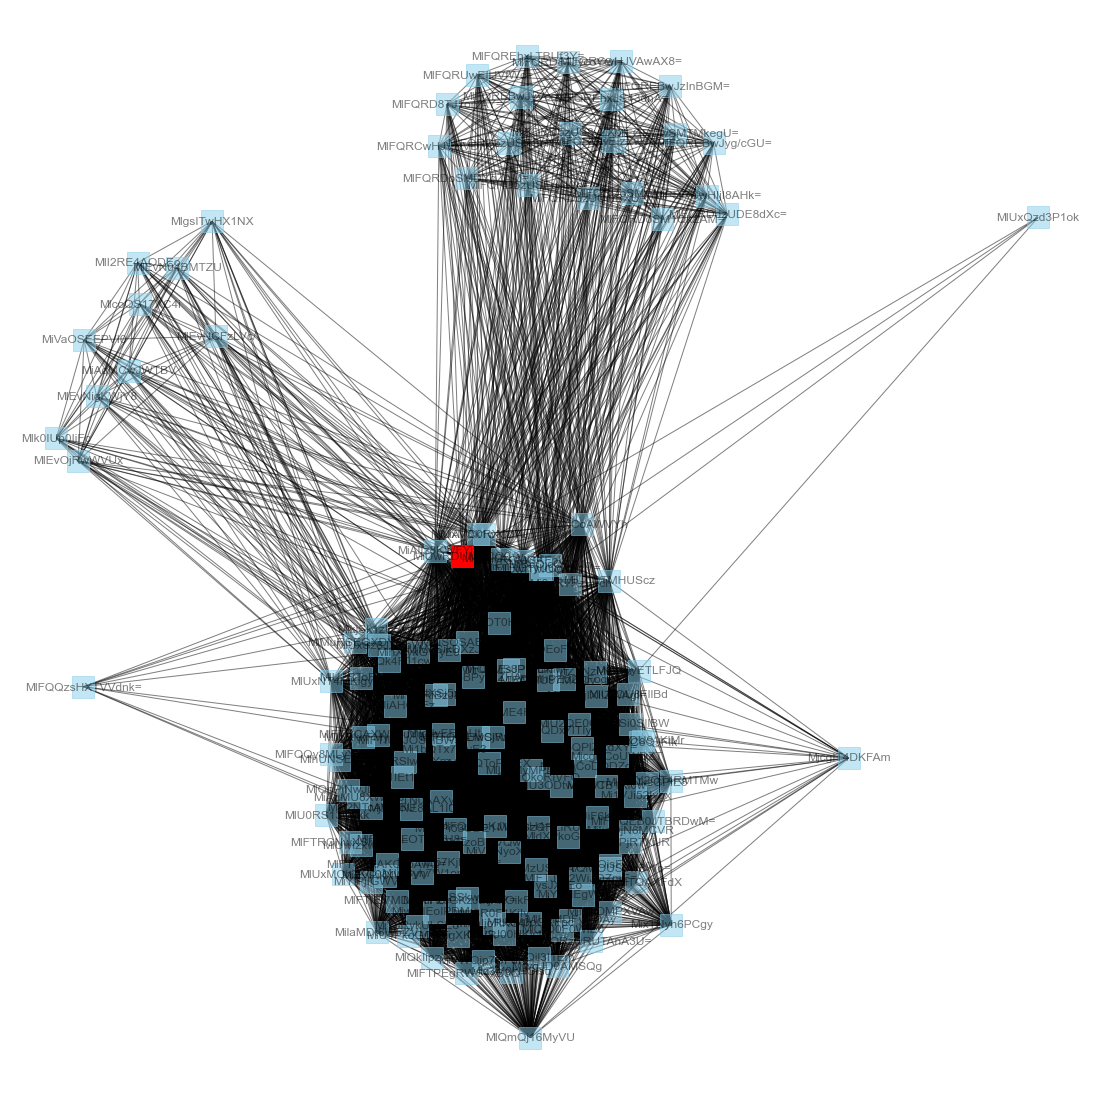

In [73]:
# create ego network
ego_node = members_ties["user_id_from"].sample(1).values[0]
hub_ego = nx.ego_graph(G_all, ego_node, radius=2, undirected=True, distance=weight_col)
display_side( hub_ego.number_of_edges(), hub_ego.number_of_nodes(), hub_ego.degree(ego_node), nx.constraint(hub_ego, nodes = [ego_node], weight=weight_col))

f = plt.figure(figsize=(15,15))

pos = nx.spring_layout(G_all)
# showing the ego network
nx.draw(hub_ego, pos, **graph_styling, with_labels = True)
  
ego_styling = graph_styling.copy()
ego_styling["node_color"] = "r"
ego_styling["alpha"] = "1"
nx.draw_networkx_nodes(hub_ego, pos, nodelist = [ego_node], **ego_styling)
  
plt.show()

## Simmelian Ties and Network Constraints

In [117]:
test_nodes = [1, 0]
display_side(G_all.nodes, '\n'.join([f"{x}\n" for x in EgoNetworkAnalyzer.get_bidirectional_connections(G_all)]))


TypeError: get_bidirectional_connections() missing 1 required positional argument: 'G'

# Network Metrics [link](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python#centrality)

## Density

In [74]:
density = nx.density(G_all)
density

0.5170443349753695

## Connectedness

In [75]:
# If your Graph has more than one component, this will return False:
print(f"Is Graph Connected?: {nx.is_connected(G_all)}")

# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G_all)
largest_component = max(components, key=len)

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.
#

subgraph = G_all.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

Is Graph Connected?: True
Network diameter of largest component: 3


## Triadic closure
_**Triadic closure supposes that if two people know the same person, they are likely to know each other**_  

If A knows both B and C, then B and C may very well know each other, completing a triangle in the visualization of three edges connecting A, B, and C.   
The number of these enclosed triangles in the network can be used to find clusters and communities of individuals that all know each other fairly well.

One way of measuring triadic closure is called clustering **coefficient** because of this clustering tendency, but the structural network measure you will learn is known as **transitiivity**.  

Transitivity is the ratio of all triangles over all possible triangles. A possible triangle exists when one person (A) knows two people (B and C).  

So transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections.  

Remember, measurements like transitivity and density concern **likelihoods** rather than certainties.   
All the outputs of your Python script must be interpreted, like any other object of research. Transitivity allows you a way of thinking about all the relationships in your graph that may exist but currently do not.

In [76]:
triadic_closure = nx.transitivity(G_all)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.9336431825502738


## Centrality
After getting some basic measures of the entire network structure, a good next step is to find which nodes are the most important ones in your network.

In network analysis, measures of the importance of nodes are referred to as centrality measures. Because there are many ways of approaching the question “Which nodes are the most important?” there are many different ways of calculating centrality. Here you’ll learn about three of the most common centrality measures: degree, betweenness centrality, and eigenvector centrality.

_**Degree**_ is the simplest and the most common way of finding important nodes. A node’s degree is the sum of its edges.   
If a node has three lines extending from it to other nodes, its degree is three. Five edges, its degree is five.   

It’s really that simple. Since each of those edges will always have a node on the other end, you might think of degree as the number of people to which a given person is directly connected.   
The nodes with the highest degree in a social network are the people who know the most people. These nodes are often referred to as _**hubs**_, and calculating degree is the quickest way of identifying hubs.   

Calculating centrality for each node in NetworkX is not quite as simple as the network-wide metrics above, but it still involves one-line commands.   
All of the centrality commands you’ll learn in this section produce dictionaries in which the keys are nodes and the values are centrality measures. That means they’re ready-made to add back into your network as a node attribute, like you did in the last section. Start by calculating degree and adding it as an attribute to your network.

In [77]:
degree_dict = dict(G_all.degree(G_all.nodes()))
nx.set_node_attributes(G_all, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)

Top 20 nodes by degree:
('MiAoNCoAWVYh', 165)
('MiAlIz8KWFYi', 154)
('MlUwRDUMXCQ0', 153)
('MiAvQk1wMDAu', 152)
('MlUxMC0RXCdW', 152)
('MjUqQTMHUScz', 147)
('MisyRCMGKFpU', 142)
('MlUwICtxWy43', 141)
('MiBbOjcQOlMo', 141)
('Mi0nRTRzLFch', 141)
('MlFTRC1yUCgxAgM=', 141)
('MlUwITMQO1E1', 140)
('MlUxOT0HXldT', 134)
('MlUxNT4MKigy', 132)
('MlhQQk4FJ1cw', 132)
('MlU2RToFX1Ey', 131)
('MiMuRSEQXDY8', 129)
('MlUxSz8JXVpW', 129)
('MlkjSk1zUSUr', 128)
('MlQmQj16MyVU', 127)


## Betweenness Centrality
Betweenness centrality is a bit different from the other two measures in that it doesn’t care about the number of edges any one node or set of nodes has.  
Betweenness centrality looks at all the shortest paths that pass through a particular node (see above).

To do this, it must first calculate every possible _**shortest**_ path in your network, so keep in mind that betweenness centrality will take longer to calculate than other centrality measures (but it won’t be an issue in a dataset of this size). Betweenness centrality, which is also expressed on a scale of 0 to 1, is fairly good at finding nodes that connect two otherwise disparate parts of a network.

If you’re the only thing connecting two clusters, every communication between those clusters has to pass through you. In contrast to a hub, this sort of node is often referred to as a _**broker**_.

Betweenness centrality is not the only way of finding brokerage (and other methods are more systematic), but it’s a quick way of giving you a sense of which nodes are important not because they have lots of connections themselves but because they stand between groups, giving the network connectivity and cohesion.

These two centrality measures are even simpler to run than degree—they don’t need to be fed a list of nodes, just the graph G. You can run them with these functions:

In [78]:
betweenness_dict = nx.betweenness_centrality(G_all) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G_all) # Run eigenvector centrality

sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

# Assign each to an attribute in your network
nx.set_node_attributes(G_all, betweenness_dict, 'betweenness')
nx.set_node_attributes(G_all, eigenvector_dict, 'eigenvector')

In [79]:
print("Top 20 nodes by betweenness centrality:")
for b in sorted_betweenness[:20]:
    print(b)

Top 20 nodes by betweenness centrality:
('MiAoNCoAWVYh', 0.12481843671323553)
('MlQmQj16MyVU', 0.0478726987439101)
('MiAvQk1wMDAu', 0.028022170343938717)
('MjUqQTMHUScz', 0.027931405387840058)
('MiAlIz8KWFYi', 0.027803487009428)
('MlUwRDUMXCQ0', 0.027152043588488748)
('MlUxMC0RXCdW', 0.024772003978364737)
('MlUxOT0HXldT', 0.01668572118730665)
('MisyRCMGKFpU', 0.014701219283411362)
('MlUwICtxWy43', 0.013927595385834648)
('MlFTRC1yUCgxAgM=', 0.013721385734313312)
('MiBbOjcQOlMo', 0.013613614988061734)
('Mi0nRTRzLFch', 0.013613614988061734)
('MlUwITMQO1E1', 0.013168048226620597)
('MlUxNT4MKigy', 0.009177244047125917)
('MlY2OT4RMTMw', 0.00899609979637885)
('MlhQQk4FJ1cw', 0.00899177249232525)
('MlU2RToFX1Ey', 0.00859068615540558)
('MiMuRSEQXDY8', 0.006189482964671518)
('MlUxSz8JXVpW', 0.006189482964671518)


In [80]:
#First get the top 20 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:20]

#Then find and print their degree
for tb in top_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree, see footnote 2
    print("Name:", tb[0], "|\t Betweenness Centrality:", tb[1], "|\t Degree:", degree)

Name: MiAoNCoAWVYh |	 Betweenness Centrality: 0.12481843671323553 |	 Degree: 165
Name: MlQmQj16MyVU |	 Betweenness Centrality: 0.0478726987439101 |	 Degree: 127
Name: MiAvQk1wMDAu |	 Betweenness Centrality: 0.028022170343938717 |	 Degree: 152
Name: MjUqQTMHUScz |	 Betweenness Centrality: 0.027931405387840058 |	 Degree: 147
Name: MiAlIz8KWFYi |	 Betweenness Centrality: 0.027803487009428 |	 Degree: 154
Name: MlUwRDUMXCQ0 |	 Betweenness Centrality: 0.027152043588488748 |	 Degree: 153
Name: MlUxMC0RXCdW |	 Betweenness Centrality: 0.024772003978364737 |	 Degree: 152
Name: MlUxOT0HXldT |	 Betweenness Centrality: 0.01668572118730665 |	 Degree: 134
Name: MisyRCMGKFpU |	 Betweenness Centrality: 0.014701219283411362 |	 Degree: 142
Name: MlUwICtxWy43 |	 Betweenness Centrality: 0.013927595385834648 |	 Degree: 141
Name: MlFTRC1yUCgxAgM= |	 Betweenness Centrality: 0.013721385734313312 |	 Degree: 141
Name: MiBbOjcQOlMo |	 Betweenness Centrality: 0.013613614988061734 |	 Degree: 141
Name: Mi0nRTRzLFch 

## Reciprocity
The first egonetwork metric we consider is its reciprocity r, which is the proportion of its edges that are bidirectional (reciprocal).   

It ranges in [0, 1] - high values correspond to socially closely-knit egonetworks, while low values correspond to linked users who each belong to differ-ent communities.

In [81]:
reciprocity = nx.overall_reciprocity(G_all)
reciprocity

0.0

## Community detection
Another common thing to ask about a network dataset is what the subgroups or communities are within the larger social structure. Is your network one big, happy family where everyone knows everyone else?  
Or is it a collection of smaller subgroups that are only connected by one or two intermediaries? The field of community detection in networks is designed to answer these questions.   

There are many ways of calculating communities, cliques, and clusters in your network, but the most popular method currently is _**modularity**_.    

Modularity is a measure of relative density in your network: a community (called a _**module**_ or _**modularity class**_) has high density relative to other nodes within its module but low density with those outside.   
Modularity gives you an overall score of how fractious your network is, and that score can be used to _**partition**_ the network and return the individual communities.13

In [119]:
communities = community.greedy_modularity_communities(G_all)
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G_all, modularity_dict, 'modularity')

In [120]:
# First get a list of just the nodes in that class
class0 = [n for n in G_all.nodes() if G_all.nodes[n]['modularity'] == 0]

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G_all.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])

Modularity Class 0 Sorted by Eigenvector Centrality:
Name: MjUqQTMHUScz | Eigenvector Centrality: 0.09368238869027261
Name: MlUxOT0HXldT | Eigenvector Centrality: 0.09224427206988309
Name: MiMuRSEQXDY8 | Eigenvector Centrality: 0.0919350634229544
Name: MlUxSz8JXVpW | Eigenvector Centrality: 0.0919350634229544
Name: MiM0OisFXzNc | Eigenvector Centrality: 0.09154097176831301


In [121]:
for i,c in enumerate(communities): # Loop through the list of communities
    if len(c) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(i)+':', list(c)) # Print out the classes and their members

Class 0: ['MiVWQip7UFdR', 'MiAyQyETLFJQ', 'MlkjSk1zUSUr', 'MioyJiAHOzEz', 'MlQjQ0F0WlE0', 'MjMoSikDXzJW', 'MlFTI0AFOTFQfH8=', 'MiIgJyEELyUt', 'MlFQQEB0JTBRDwM=', 'MldXPkoGJC9W', 'MjcgIT4DKFAm', 'MlFTIEl7MDEvdHc=', 'MiM0OisFXzNc', 'MiYvIC8QJFIk', 'MjVSSkwTKjIo', 'MlFQRjIXIlZWAgI=', 'MlU0RS13Oykk', 'MlFTJkh2WiJQZmE=', 'MlU3ODtwOFVT', 'MiZVPikXWFVV', 'MlFTRCNwXSIwD3g=', 'MjRUOEoFWVNX', 'MlU1IEt1PjAi', 'MlFQRzwRUTAnA3U=', 'MiU3R0F1KjIv', 'MlQkIipzXTdU', 'MlUwIzxwKisg', 'MlFQQzsHXTVVdnk=', 'MlFTOjEEMClWBHg=', 'MiU4PkoGOTYi', 'MiZbQToPOlFX', 'MjNXSj5xOi8j', 'MlUxOU8FIlBd', 'MlFTPzcGKzJcdmY=', 'MjdUQDcDJ1Qr', 'MjIqPDMPXVAw', 'MixTNyh6PCgy', 'MiZbMTQAXFdX', 'MlUxSz8JXVpW', 'MjU2J00HKjct', 'MiYsMD4QPFFU', 'MjQ1MS8PLydX', 'Mlc3M0kHOlsu', 'MjVUNyoXKC4x', 'MiZbNzMJXigr', 'MjM4IEB6JTVT', 'MiMhPE52OFog', 'MlUwSjRxLy8/', 'MlUxMyMPLSJQ', 'Mi1aMzUSXzA/', 'MlFTQiwOUS8wBWo=', 'MiUlSyh7W1op', 'MlhXIykGWyE9', 'MlQpPiNwJDVX', 'MlY3ICB1Xi0w', 'MlUxNksGPlE8', 'MlUwSi0SIlBW', 'MlUxMDFyODAy', 'MlFTIE57KjMtYwc='

## Testing constraints

In [109]:
from constraints_custom import *
import random

In [110]:
reload(constraints_custom)
def calculate_metrics(edgelist, egos, ego_radius=2, graph=None, all_constraints=True, figsize=5, nodesize=600, export_fig=True, font_size=25):
    f, axs = plt.subplots(1,len(egos), figsize=(figsize*len(egos)+1,figsize))
    graph_styling ={ "node_size":nodesize, "node_color":"skyblue", "alpha":0.8, "linewidths":20}
    
    if graph is None:
        G = nx.Graph()
        if len(edgelist[0]) > 2:
            G.add_weighted_edges_from(edgelist)
        else:
            G.add_edges_from(edgelist)
    else:
        G = graph
    labels = nx.get_edge_attributes(G,'weight')
        
    if all_constraints:
        nodes_list = ["full"]+list(G.nodes)
    else:
        nodes_list= egos
    
    """ Setting up Summary Dataframes """
    constr_summary = pd.DataFrame({"node": nodes_list})
        
    for i in range(1, len(nodes_list)):
        node = nodes_list[i]
        constr_summary[node] = ""
    constr_summary["sum"] = 0
    constr_summary["len"] = 0
    constr_summary["ego_degree"] = 0
    constr_summary["network_degree"] = 0
    constr_summary = constr_summary.set_index("node", drop=True)
    size_summary = constr_summary.copy()
    constr_summary["ego_constr"] = 0
    my_constr_summary = constr_summary.copy()
    size_summary["ego_sz"] = 0
    
    full_index = -1 if all_constraints else 0
    for i in range(full_index, len(egos)):
        net = G
        row_idx = "full"
        ego = None
        if i >= 0:
            ego = egos[i]
            row_idx = ego
            net = nx.ego_graph(G, ego, undirected=True, radius=ego_radius, distance=None)
        pos = nx.spring_layout(net, seed=random.randint(0, 10000000))
        # showing the ego network
        ego_styling = graph_styling.copy()
        ego_styling["node_color"] = "r"
        ego_styling["alpha"] = "1"
        
        """ NetowrkX built-in constraints function"""        
        if all_constraints:
            constr = nx.constraint(net, weight='weight')
        else:
            constr = nx.constraint(net, nodes=[ego], weight='weight')
        for key, value in constr.items():
            constr_summary.loc[row_idx,key] = value
        constr_summary.loc[row_idx,"sum"] = sum(constr.values())
        constr_summary.loc[row_idx,"len"] = len(constr.values())

        """ Custom implemented constraints function"""
        if all_constraints:
            my_constr = custom_constraints(net, weight_attr='weight')
        else:
            my_constr = custom_constraints(net, nodes=[ego], weight_attr='weight')
        for key, value in my_constr.items():
            my_constr_summary.loc[row_idx,key] = value      
        my_constr_summary.loc[row_idx,"sum"] = sum(my_constr.values())
        my_constr_summary.loc[row_idx, "len"] = len(my_constr.values())  

        """ Effective Size (extra )"""
#         sz = nx.effective_size(net)
#         for key, value in sz.items():
#             size_summary.loc[row_idx,key] = value        
#         size_summary.loc[row_idx, "sum"] = sum(sz.values())  
#         size_summary.loc[row_idx, "len"] = len(sz.values())
        if isinstance(axs, list) or isinstance(axs, np.ndarray) :
            ax=axs[i-1]
        else:
            ax=axs
        title = 'Full Graph'
        if i >=0: 
            nx.draw(net, pos, **graph_styling, with_labels=True, ax=ax, font_size=font_size)
            constr_summary.loc[row_idx,"ego_degree"] = net.degree(ego)
            constr_summary.loc[row_idx,"network_degree"] = net.number_of_edges()
            constr_summary.loc[row_idx,"ego_constr"] = constr[ego]
            my_constr_summary.loc[row_idx,"ego_degree"] = net.degree(ego)
            my_constr_summary.loc[row_idx,"network_degree"] = net.number_of_edges()
            my_constr_summary.loc[row_idx,"ego_constr"] = my_constr[ego]
#             size_summary.loc[row_idx, "ego_sz"] = sz[ego]
#             size_summary.loc[row_idx, "network_degree"] = net.number_of_edges()
#             size_summary.loc[row_idx, "ego_degree"] = net.degree(ego)
            title = 'Ego '+str(ego) +' Graph'       
            nx.draw_networkx_nodes(net, pos, nodelist = [ego], **ego_styling, ax=ax) 
            nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    #         ties = calculate_simmelian_ties(net, ego)
    #         for key, value in ties.items():
    #             constr_summary.loc[row_idx,key] = value
    #             my_constr_summary[row_idx,key] = value
        ax.set_title(title)
        ax.margins(0.25, 0.25)

    # display_side(constr_summary, size_summary, titles=["Constraints", "Effective Size"])
    display_side(constr_summary, my_constr_summary, titles=["Constraints", "Custom Constraints"])
    f.tight_layout()
    if export_fig:
        f.savefig('egonetwork_plot_new.png')
    display_side(constr_summary.corr("pearson"),my_constr_summary.corr("pearson"), titles=["NX Pearson", "Custom Pearson"])
    display_side(constr_summary.corr("spearman"),my_constr_summary.corr("spearman"), titles=["NX Spearman", "Custom Spearman"])
    # display_side(corr_plot(constr_summary.corr("pearson"), "test_pearson", constr_summary.columns, filtered=False),
    # corr_plot(constr_summary.corr("pearson"), "test_spearman", constr_summary.columns, filtered=False))

Constraints 
 
 
 
 A 
 B 
 C 
 D 
 E 
 F 
 G 
 H 
 I 
 J 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 
 
 node 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 full 
 1 
 0.521111 
 0.804444 
 0.418933 
 0.248711 
 0.641111 
 1 
 1 
 1 
 0.804444 
 7.438756 
 10 
 0 
 0 
 0.000000 
 
 
 A 
 1 
 0.611111 
 1.00694 
 1.00694 
 
 
 
 
 
 
 3.625000 
 4 
 1 
 4 
 1.000000 
 
 
 B 
 1 
 0.521111 
 0.804444 
 0.463333 
 0.804444 
 0.764444 
 
 
 
 0.804444 
 5.162222 
 7 
 3 
 9 
 0.521111 
 
 
 C 
 1 
 0.521111 
 0.804444 
 0.463333 
 0.804444 
 0.764444 
 
 
 
 0.804444 
 5.162222 
 7 
 2 
 9 
 0.804444 
 
 
 D 
 1 
 0.521111 
 0.804444 
 0.418933 
 0.248711 
 0.641111 
 1 
 1 
 1 
 0.804444 
 7.438756 
 10 
 5 
 12 
 0.418933 
 
 
 E 
 
 0.9225 
 0.9225 
 0.437822 
 0.248711 
 0.641111 
 1 
 1 
 1 
 0.804444 
 6.977089 
 9 
 5 
 11 
 0.248711 
 
 
 F 
 
 0.9225 
 0.9225 
 0.437822 
 0.248711 
 0.641111 
 1 
 1 
 1 
 0.804444 
 6.977089 
 9 
 3 
 11 
 0.641111 
 
 
 G 
 
 
 
 0.9225 
 0.3 
 0.9225 
 1 
 1 
 1 
 
 5.145000 
 6 
 1 
 6 
 1.000000 
 
 
 H 
 
 
 
 0.9225 
 0.3 
 0.9225 
 1 
 1 
 1 
 
 5.145000 
 6 
 1 
 6 
 1.000000 
 
 
 I 
 
 
 
 0.9225 
 0.3 
 0.9225 
 1 
 1 
 1 
 
 5.145000 
 6 
 1 
 6 
 1.000000 
 
 
 J 
 
 0.9225 
 0.9225 
 0.482222 
 0.804444 
 0.764444 
 
 
 
 0.804444 
 4.700556 
 6 
 2 
 8 
 0.804444 
 
 
 Custom Constraints 
 
 
 
 A 
 B 
 C 
 D 
 E 
 F 
 G 
 H 
 I 
 J 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 
 
 node 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 full 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 10 
 0 
 0 
 0 
 
 
 A 
 0 
 0 
 0 
 0 
 
 
 
 
 
 
 0 
 4 
 1 
 4 
 0 
 
 
 B 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 
 0 
 0 
 7 
 3 
 9 
 0 
 
 
 C 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 
 0 
 0 
 7 
 2 
 9 
 0 
 
 
 D 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 10 
 5 
 12 
 0 
 
 
 E 
 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 9 
 5 
 11 
 0 
 
 
 F 
 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 9 
 3 
 11 
 0 
 
 
 G 
 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 
 0 
 6 
 1 
 6 
 0 
 
 
 H 
 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 
 0 
 6 
 1 
 6 
 0 
 
 
 I 
 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 
 0 
 6 
 1 
 6 
 0 
 
 
 J 
 
 0 
 0 
 0 
 0 
 0 
 
 
 
 0 
 0 
 6 
 2 
 8 
 0

NX Pearson 
 
 
 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 
 
 
 
 sum 
 1.000000 
 0.982620 
 0.474381 
 0.253865 
 -0.810284 
 
 
 len 
 0.982620 
 1.000000 
 0.506544 
 0.284546 
 -0.862239 
 
 
 ego_degree 
 0.474381 
 0.506544 
 1.000000 
 0.887239 
 -0.382427 
 
 
 network_degree 
 0.253865 
 0.284546 
 0.887239 
 1.000000 
 -0.022364 
 
 
 ego_constr 
 -0.810284 
 -0.862239 
 -0.382427 
 -0.022364 
 1.000000 
 
 
 Custom Pearson 
 
 
 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 
 
 
 
 sum 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 len 
 NaN 
 1.000000 
 0.506544 
 0.284546 
 NaN 
 
 
 ego_degree 
 NaN 
 0.506544 
 1.000000 
 0.887239 
 NaN 
 
 
 network_degree 
 NaN 
 0.284546 
 0.887239 
 1.000000 
 NaN 
 
 
 ego_constr 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN

NX Spearman 
 
 
 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 
 
 
 
 sum 
 1.000000 
 0.985815 
 0.402422 
 0.477753 
 -0.850749 
 
 
 len 
 0.985815 
 1.000000 
 0.451691 
 0.513135 
 -0.906260 
 
 
 ego_degree 
 0.402422 
 0.451691 
 1.000000 
 0.964504 
 -0.466352 
 
 
 network_degree 
 0.477753 
 0.513135 
 0.964504 
 1.000000 
 -0.423197 
 
 
 ego_constr 
 -0.850749 
 -0.906260 
 -0.466352 
 -0.423197 
 1.000000 
 
 
 Custom Spearman 
 
 
 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 
 
 
 
 sum 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 len 
 NaN 
 1.000000 
 0.451691 
 0.513135 
 NaN 
 
 
 ego_degree 
 NaN 
 0.451691 
 1.000000 
 0.964504 
 NaN 
 
 
 network_degree 
 NaN 
 0.513135 
 0.964504 
 1.000000 
 NaN 
 
 
 ego_constr 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN

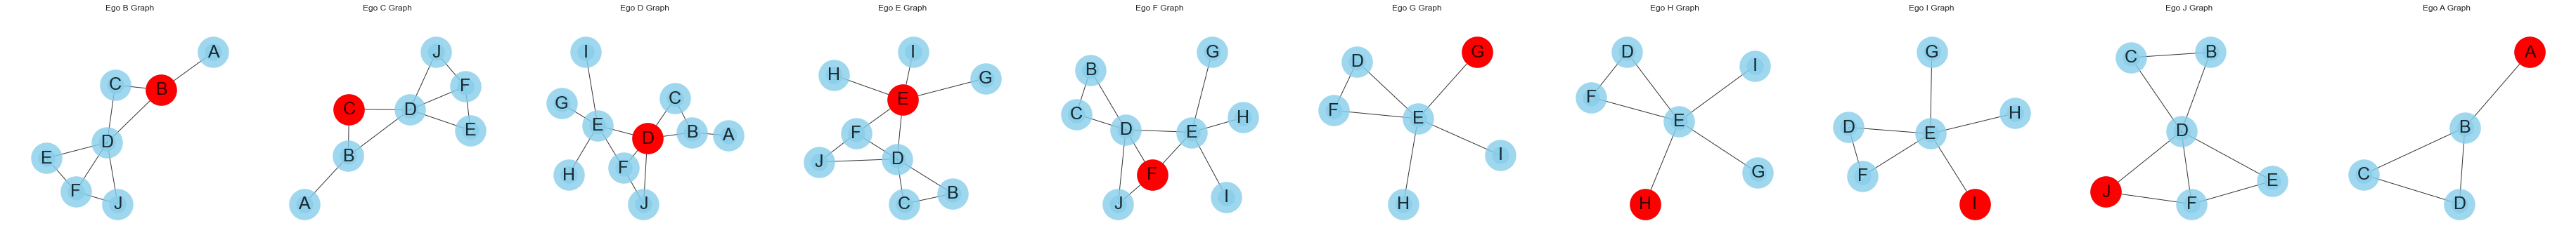

In [111]:
""" Custom network """
egos_to_compute = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
edgelist = [("A", "B",), ("B", "C"), ("C", "D"), ("C", "B"), ("D", "B"), ("D", "E"), ("E", "F"), ("E", "G"), ("E", "H"), ("E", "I"), ("F", "D"), ("F", "J"), ("D", "J")]
calculate_metrics(edgelist, egos_to_compute, ego_radius=2)

KeyError: 'F'

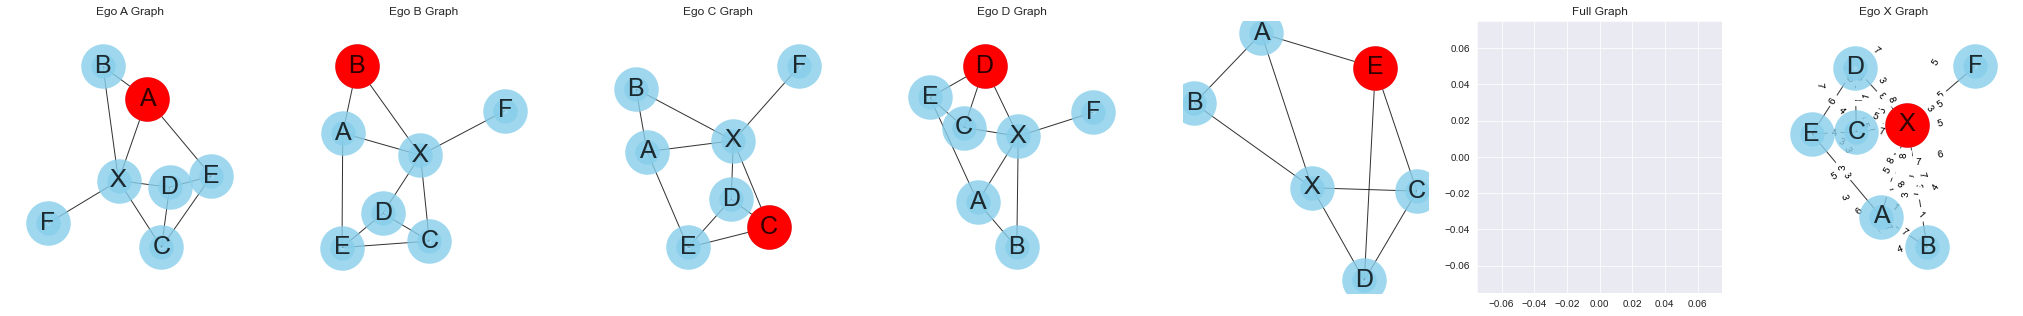

In [112]:
""" Network from this paper (https://www.aaai.org/ocs/index.php/ICWSM/ICWSM12/paper/viewPDFInterstitial/4612/4996) figure 1 (undirected)"""
egos_to_compute = ["X", "A", "B", "C", "D", "E", "F"]
edgelist = [("X", "A", 5), ("X", "B", 3), ("X", "C", 7), ("X", "D", 8), ("D", "C",1), ("D", "E", 2), ("X", "F",5), ("E", "D", 6), ("E", "C",4), ("E", "A",3), ("A", "B",7)]
calculate_metrics(edgelist, egos_to_compute, ego_radius=2)

Constraints 
 
 
 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 X 
 
 
 node 
 
 
 
 
 
 
 
 
 
 
 X 
 0.298825 
 1 
 5 
 10 
 0.298825 
 0.298825 
 
 
 Custom Constraints 
 
 
 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 X 
 
 
 node 
 
 
 
 
 
 
 
 
 
 
 X 
 0.298825 
 1 
 5 
 10 
 0.298825 
 0.298825

NX Pearson 
 
 
 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 X 
 
 
 
 
 sum 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 len 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ego_degree 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 network_degree 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ego_constr 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 X 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 Custom Pearson 
 
 
 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 X 
 
 
 
 
 sum 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 len 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ego_degree 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 network_degree 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ego_constr 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 X 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN

NX Spearman 
 
 
 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 X 
 
 
 
 
 sum 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 len 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ego_degree 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 network_degree 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ego_constr 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 X 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 Custom Spearman 
 
 
 
 sum 
 len 
 ego_degree 
 network_degree 
 ego_constr 
 X 
 
 
 
 
 sum 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 len 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ego_degree 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 network_degree 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ego_constr 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 X 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN

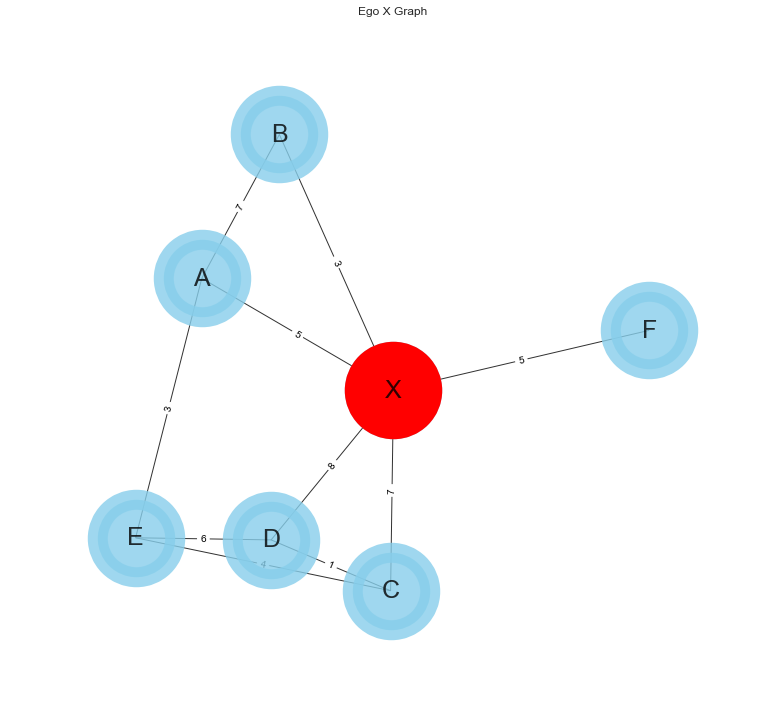

In [122]:
egos_to_compute = ["X"]
edgelist = [("X", "A", 5), ("X", "B", 3), ("X", "C", 7), ("X", "D", 8), ("X", "F",5), ("D", "C",1), ("D", "E", 2), ("E", "D", 6), ("E", "C",4), ("E", "A",3), ("A", "B",7)]
calculate_metrics(edgelist, egos_to_compute, ego_radius=2, figsize=10, nodesize=6000, all_constraints=False, export_fig=True)